# 1.24b: Epoch Detection and Deceleration Dynamics

**Purpose:** Algorithmically detect the three core epochs and characterize the chaotic middle.

## Three Core Epochs (Universal)

1. **The Sneeze** (explosive thermal expansion)
   - Start: t=0
   - End: Peak velocity (max dr/dt)
   
2. **Deceleration** (the long middle)
   - Start: Peak velocity
   - End: Fimbulwinter onset (>90% frozen)
   
3. **Fimbulwinter** (quantization freeze)
   - Start: >90% frozen
   - End: Training ends

## Optional Features

- **Inhale**: Local minimum in radius during early Sneeze (t=0-20)
- **Re-expansion**: Sign change in acceleration during Deceleration (velocity stops decreasing and increases again)

## What We'll Measure

- Radius r(t), velocity v(t) = dr/dt, acceleration a(t) = dv/dt
- Frozen fraction over time
- Deceleration dynamics: displacement histograms, velocity variance, jerkiness

## Parameters

In [1]:
# Data path
DATA_PATH = "../tensors/Flannel/1.20h_flannel_7.safetensors"
MASK_PATH = "../tensors/Flannel/live_dead_tokens.safetensors"

# Detection parameters
EARLY_WINDOW = 20  # Window for detecting Inhale
FREEZE_THRESHOLD = 0.9  # Fraction frozen for Fimbulwinter onset

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading Flannel 7 data...\n")

data = load_file(DATA_PATH)

# Extract W matrix
W = data['W'][0].float()  # (1001, 10000, 64)

# Load token masks
mask_data = load_file(MASK_PATH)
dead_mask = mask_data['dead_mask'].bool()
live_mask = mask_data['live_mask'].bool()

print(f"W shape: {tuple(W.shape)}")
print(f"Dead tokens: {dead_mask.sum().item()}")
print(f"\n✓ Data loaded")

Loading Flannel 7 data...

W shape: (1001, 10000, 64)
Dead tokens: 3699

✓ Data loaded


## Compute Kinematic Quantities

In [5]:
print("Computing radius, velocity, acceleration...\n")

# Extract dead tokens
W_dead = W[:, dead_mask, :]  # (1001, 3699, 64)

# Radius from origin
radii = torch.norm(W_dead, dim=2)  # (1001, 3699)
mean_radius = radii.mean(dim=1)  # (1001,)

# Velocity (first derivative)
velocity = torch.diff(mean_radius)  # (1000,)

# Acceleration (second derivative)
acceleration = torch.diff(velocity)  # (999,)

# Frozen fraction
displacements = torch.norm(W_dead[1:] - W_dead[:-1], dim=2)  # (1000, 3699)
frozen_mask = (displacements == 0)  # (1000, 3699)
fraction_frozen = frozen_mask.float().mean(dim=1)  # (1000,)

print(f"Mean radius: {tuple(mean_radius.shape)}")
print(f"Velocity: {tuple(velocity.shape)}")
print(f"Acceleration: {tuple(acceleration.shape)}")
print(f"Fraction frozen: {tuple(fraction_frozen.shape)}")
print(f"\n✓ Kinematics computed")

Computing radius, velocity, acceleration...

Mean radius: (1001,)
Velocity: (1000,)
Acceleration: (999,)
Fraction frozen: (1000,)

✓ Kinematics computed


## Detect Core Epoch Boundaries

In [6]:
print("="*80)
print("DETECTING CORE EPOCH BOUNDARIES")
print("="*80 + "\n")

# 1. Sneeze ends at peak velocity
t_sneeze_end = velocity.argmax().item()

print(f"The Sneeze:")
print(f"  Start: t=0")
print(f"  End:   t={t_sneeze_end} (peak velocity)")
print(f"  Peak velocity: {velocity[t_sneeze_end]:.6f} units/step")
print()

# 2. Fimbulwinter starts when >90% frozen
fimbulwinter_mask = fraction_frozen > FREEZE_THRESHOLD
if fimbulwinter_mask.any():
    t_fimbulwinter_start = fimbulwinter_mask.nonzero()[0].item()
else:
    t_fimbulwinter_start = len(fraction_frozen)  # Never reached

print(f"Deceleration:")
print(f"  Start: t={t_sneeze_end}")
print(f"  End:   t={t_fimbulwinter_start} (Fimbulwinter onset)")
print(f"  Duration: {t_fimbulwinter_start - t_sneeze_end} steps")
print()

print(f"Fimbulwinter:")
print(f"  Start: t={t_fimbulwinter_start} ({fraction_frozen[t_fimbulwinter_start]:.1%} frozen)")
print(f"  End:   t={len(mean_radius)-1} (training ends)")
print(f"  Duration: {len(mean_radius) - 1 - t_fimbulwinter_start} steps")

print("\n" + "="*80 + "\n")

DETECTING CORE EPOCH BOUNDARIES

The Sneeze:
  Start: t=0
  End:   t=27 (peak velocity)
  Peak velocity: 0.005068 units/step

Deceleration:
  Start: t=27
  End:   t=597 (Fimbulwinter onset)
  Duration: 570 steps

Fimbulwinter:
  Start: t=597 (91.7% frozen)
  End:   t=1000 (training ends)
  Duration: 403 steps




## Detect Optional Features

In [7]:
print("="*80)
print("DETECTING OPTIONAL FEATURES")
print("="*80 + "\n")

# 1. Inhale: Local minimum in radius during early Sneeze
early_radius = mean_radius[:EARLY_WINDOW]
t_inhale_min = early_radius.argmin().item()
inhale_present = (t_inhale_min > 0) and (early_radius[t_inhale_min] < early_radius[0])

if inhale_present:
    contraction = (early_radius[0] - early_radius[t_inhale_min]) / early_radius[0]
    print(f"✓ Inhale detected:")
    print(f"  Local minimum at t={t_inhale_min}")
    print(f"  Contraction: {contraction*100:.2f}%")
else:
    print(f"✗ No inhale detected (radius monotonically increasing in t=0-{EARLY_WINDOW})")
    t_inhale_min = None

print()

# 2. Re-expansion: Sign change in acceleration during Deceleration
# Look for local minimum in velocity (acceleration changes from negative to positive)
decel_velocity = velocity[t_sneeze_end:t_fimbulwinter_start]
decel_acceleration = acceleration[t_sneeze_end:t_fimbulwinter_start-1]

# Find sign changes: negative -> positive (local min in velocity)
sign_changes = []
for i in range(1, len(decel_acceleration)):
    if decel_acceleration[i-1] < 0 and decel_acceleration[i] > 0:
        sign_changes.append(i + t_sneeze_end)

if len(sign_changes) > 0:
    # Take the most prominent sign change (deepest local minimum in velocity)
    # Look in neighborhood of each sign change for velocity minimum
    candidates = []
    for t_change in sign_changes:
        window_start = max(t_sneeze_end, t_change - 10)
        window_end = min(t_fimbulwinter_start, t_change + 10)
        local_min = velocity[window_start:window_end].argmin().item() + window_start
        candidates.append(local_min)
    
    # Pick the one with lowest velocity
    t_reexpansion_start = min(candidates, key=lambda t: velocity[t].item())
    
    print(f"✓ Re-expansion detected:")
    print(f"  Velocity minimum at t={t_reexpansion_start}")
    print(f"  Minimum velocity: {velocity[t_reexpansion_start]:.6f} units/step")
    print(f"  Acceleration changes sign: negative → positive → negative")
    reexpansion_present = True
else:
    print(f"✗ No re-expansion detected (acceleration negative throughout Deceleration)")
    print(f"  Interpretation: Monotonic deceleration to freeze")
    t_reexpansion_start = None
    reexpansion_present = False

print("\n" + "="*80 + "\n")

DETECTING OPTIONAL FEATURES

✓ Inhale detected:
  Local minimum at t=2
  Contraction: 0.55%

✓ Re-expansion detected:
  Velocity minimum at t=595
  Minimum velocity: 0.000010 units/step
  Acceleration changes sign: negative → positive → negative




## Visualize Epochs

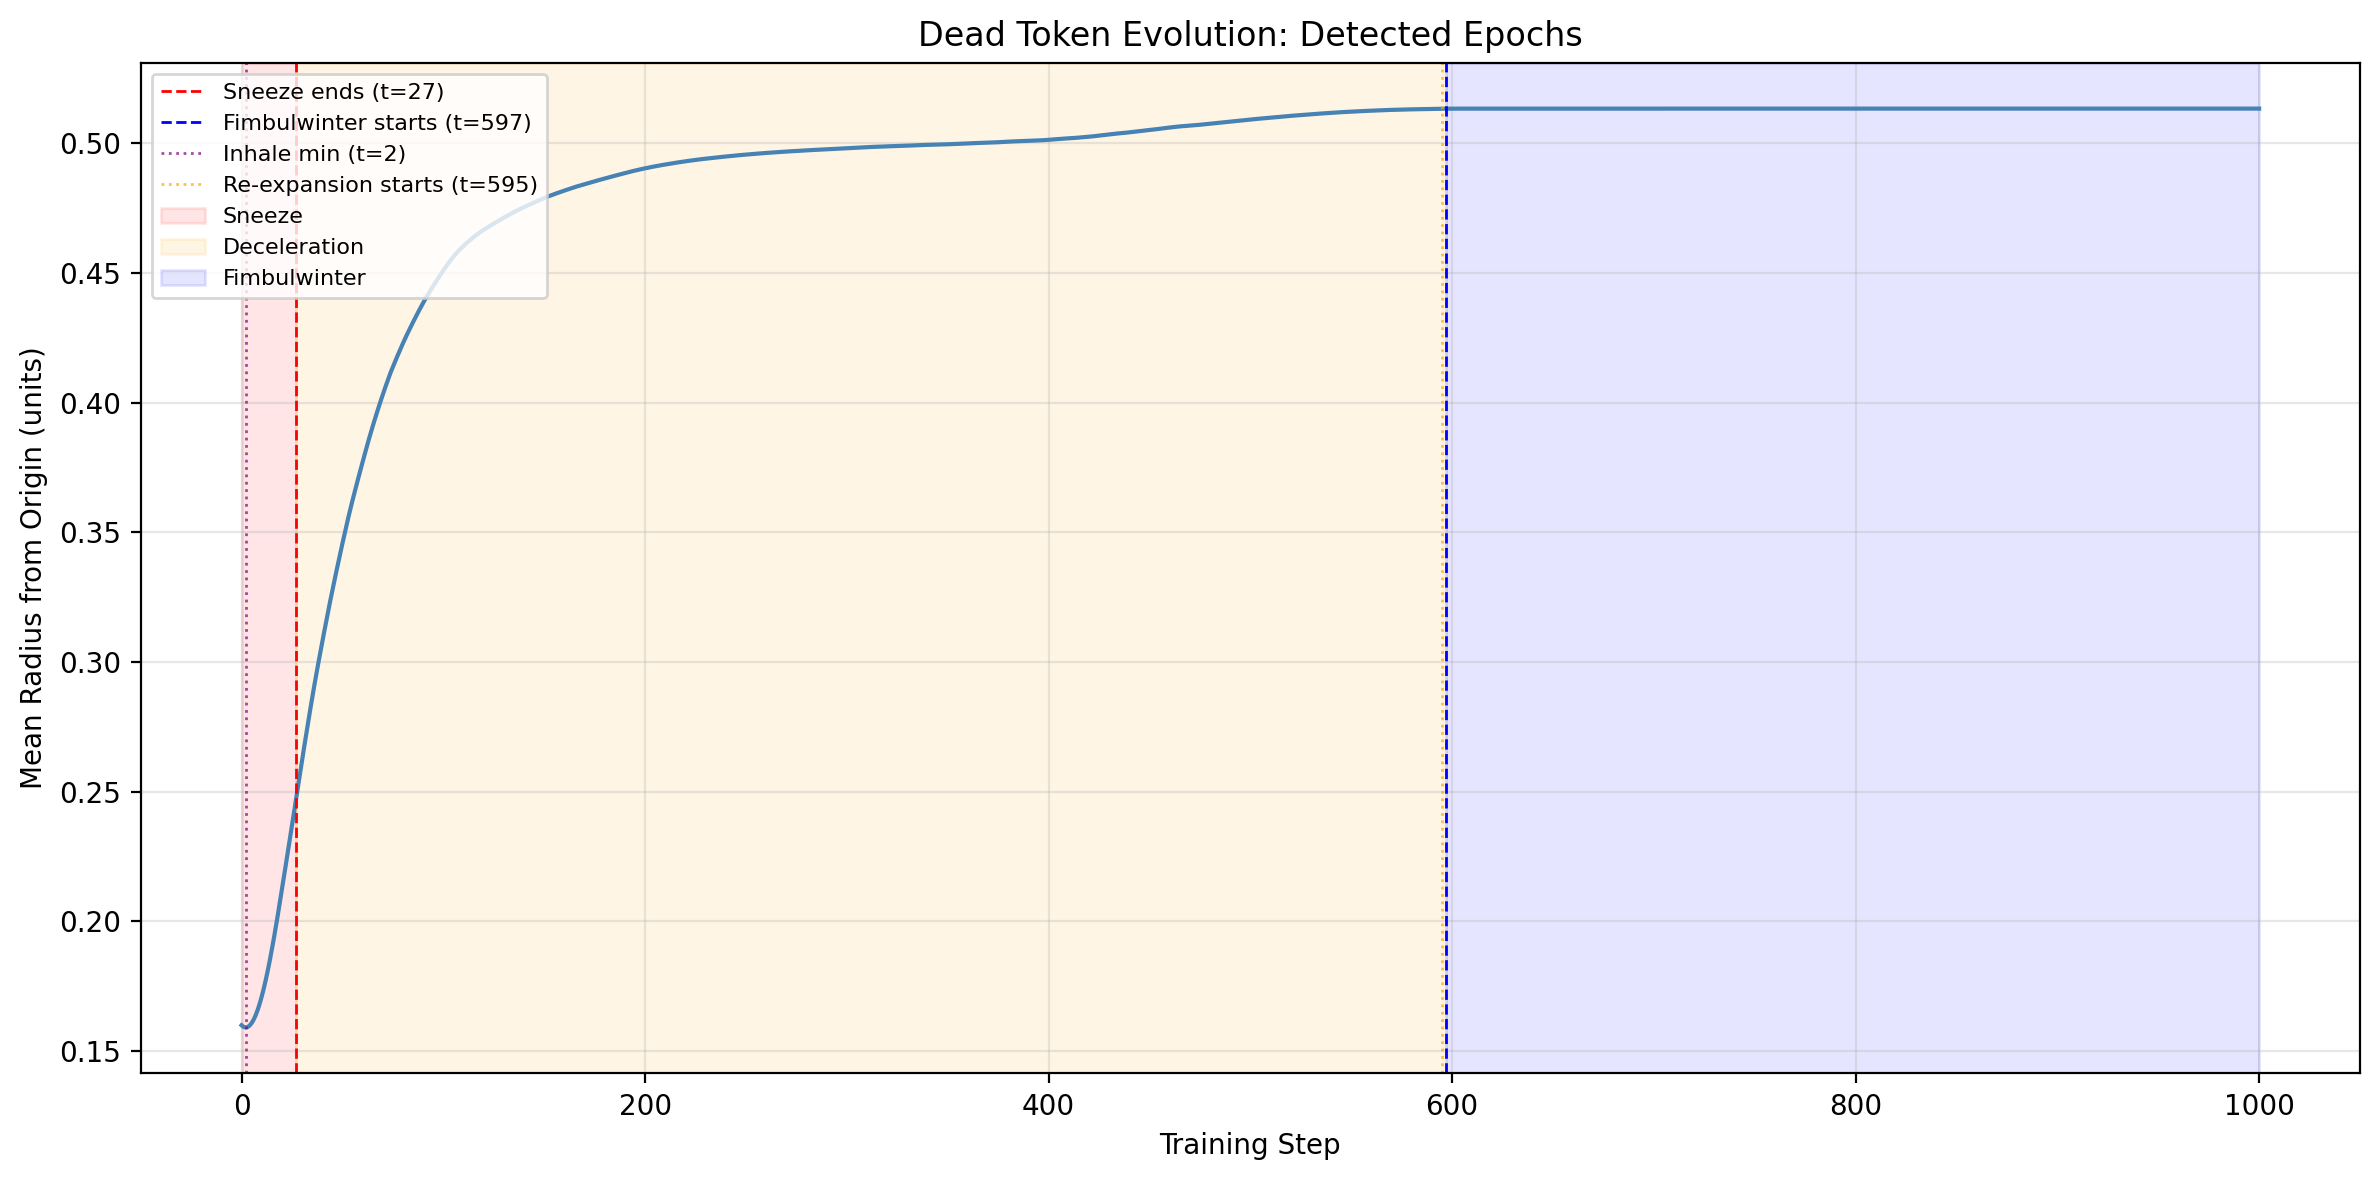

In [8]:
# Plot 1: Radius with detected boundaries
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(mean_radius.numpy(), linewidth=1.5, color='steelblue')

# Mark boundaries
ax.axvline(t_sneeze_end, color='red', linestyle='--', linewidth=1, label=f'Sneeze ends (t={t_sneeze_end})')
ax.axvline(t_fimbulwinter_start, color='blue', linestyle='--', linewidth=1, label=f'Fimbulwinter starts (t={t_fimbulwinter_start})')

# Mark optional features
if inhale_present:
    ax.axvline(t_inhale_min, color='purple', linestyle=':', linewidth=1, alpha=0.7, label=f'Inhale min (t={t_inhale_min})')

if reexpansion_present:
    ax.axvline(t_reexpansion_start, color='orange', linestyle=':', linewidth=1, alpha=0.7, label=f'Re-expansion starts (t={t_reexpansion_start})')

# Shade epochs
ax.axvspan(0, t_sneeze_end, alpha=0.1, color='red', label='Sneeze')
ax.axvspan(t_sneeze_end, t_fimbulwinter_start, alpha=0.1, color='orange', label='Deceleration')
ax.axvspan(t_fimbulwinter_start, len(mean_radius)-1, alpha=0.1, color='blue', label='Fimbulwinter')

ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Radius from Origin (units)')
ax.set_title('Dead Token Evolution: Detected Epochs')
ax.legend(loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

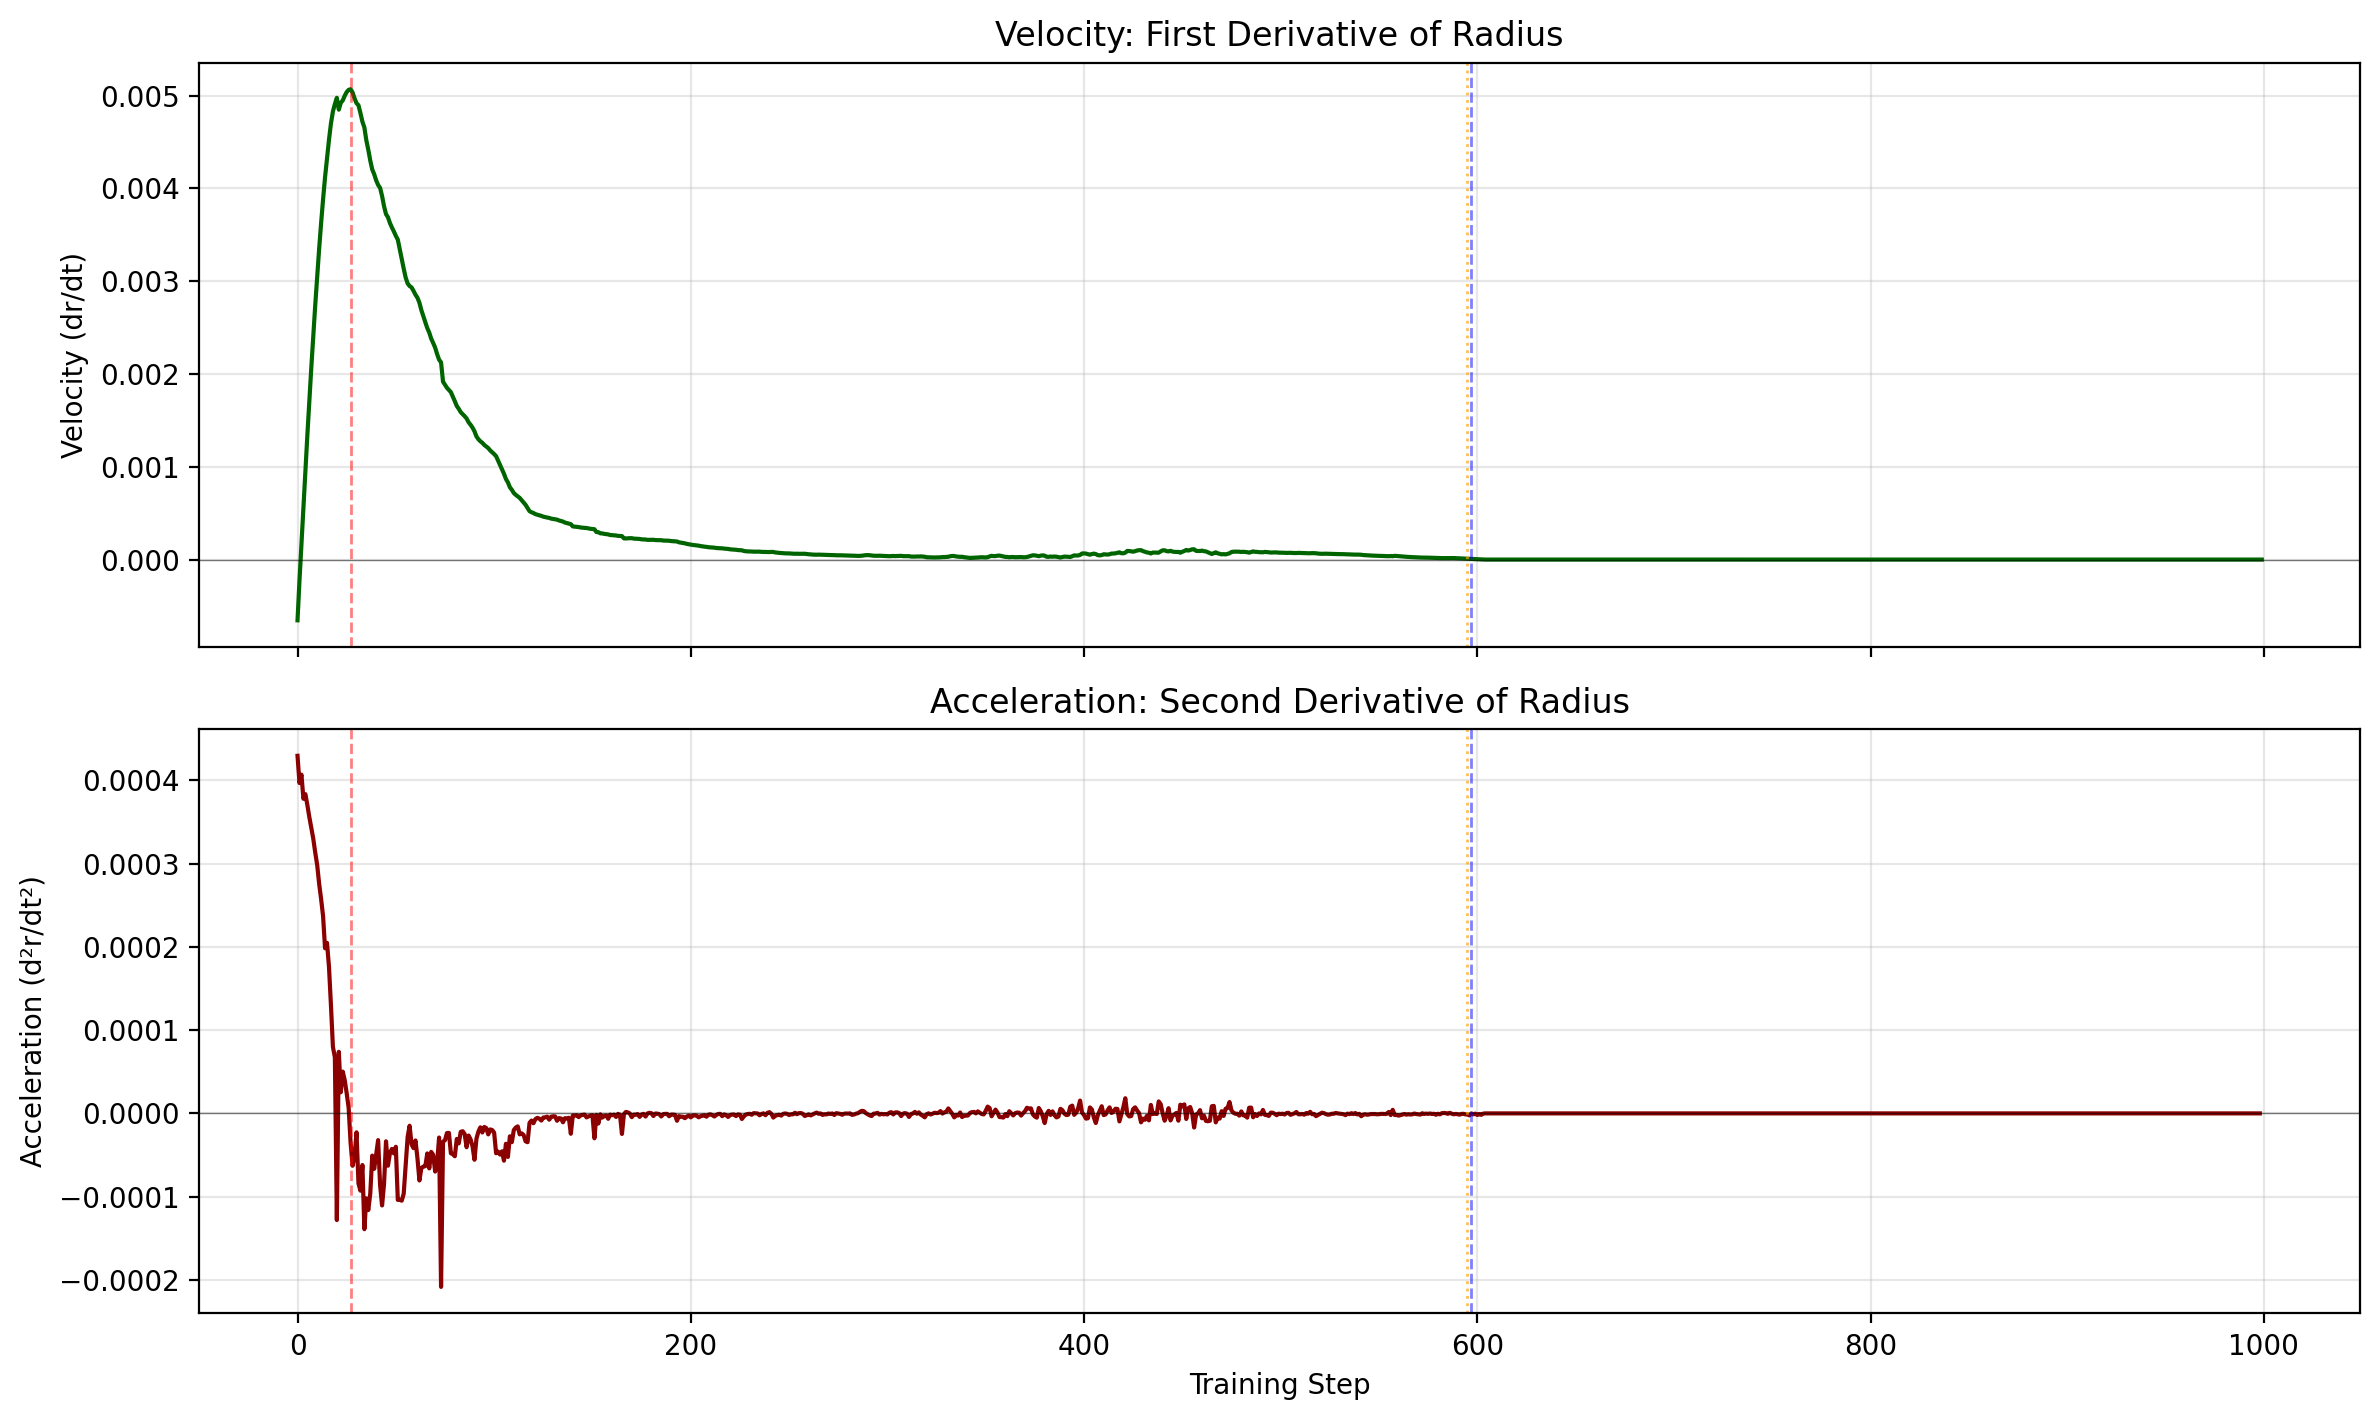

In [9]:
# Plot 2: Velocity and Acceleration
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(FIGSIZE[0], FIGSIZE[1]*1.2), dpi=DPI, sharex=True)

# Velocity
ax1.plot(velocity.numpy(), linewidth=1.5, color='darkgreen')
ax1.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax1.axvline(t_sneeze_end, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.axvline(t_fimbulwinter_start, color='blue', linestyle='--', linewidth=1, alpha=0.5)
if reexpansion_present:
    ax1.axvline(t_reexpansion_start, color='orange', linestyle=':', linewidth=1, alpha=0.7)
ax1.set_ylabel('Velocity (dr/dt)')
ax1.set_title('Velocity: First Derivative of Radius')
ax1.grid(True, alpha=0.3)

# Acceleration
ax2.plot(acceleration.numpy(), linewidth=1.5, color='darkred')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax2.axvline(t_sneeze_end, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.axvline(t_fimbulwinter_start, color='blue', linestyle='--', linewidth=1, alpha=0.5)
if reexpansion_present:
    ax2.axvline(t_reexpansion_start, color='orange', linestyle=':', linewidth=1, alpha=0.7)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Acceleration (d²r/dt²)')
ax2.set_title('Acceleration: Second Derivative of Radius')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Deceleration Dynamics: The Chaotic Middle

In [10]:
print("="*80)
print("DECELERATION DYNAMICS: THE CHAOTIC MIDDLE")
print("="*80 + "\n")

# Extract Deceleration window
decel_start = t_sneeze_end
decel_end = t_fimbulwinter_start

print(f"Analyzing Deceleration epoch: t={decel_start} to t={decel_end}")
print(f"Duration: {decel_end - decel_start} steps\n")

# Per-token displacements during Deceleration
decel_displacements = displacements[decel_start:decel_end, :]  # (duration, 3699)

print(f"Displacement statistics:")
print(f"  Mean: {decel_displacements.mean():.6f} units/step")
print(f"  Std:  {decel_displacements.std():.6f} units/step")
print(f"  Min:  {decel_displacements.min():.6f} units/step")
print(f"  Max:  {decel_displacements.max():.6f} units/step")

print("\n" + "="*80 + "\n")

DECELERATION DYNAMICS: THE CHAOTIC MIDDLE

Analyzing Deceleration epoch: t=27 to t=597
Duration: 570 steps

Displacement statistics:
  Mean: 0.000806 units/step
  Std:  0.001145 units/step
  Min:  0.000000 units/step
  Max:  0.006873 units/step




### Displacement Histograms Over Time

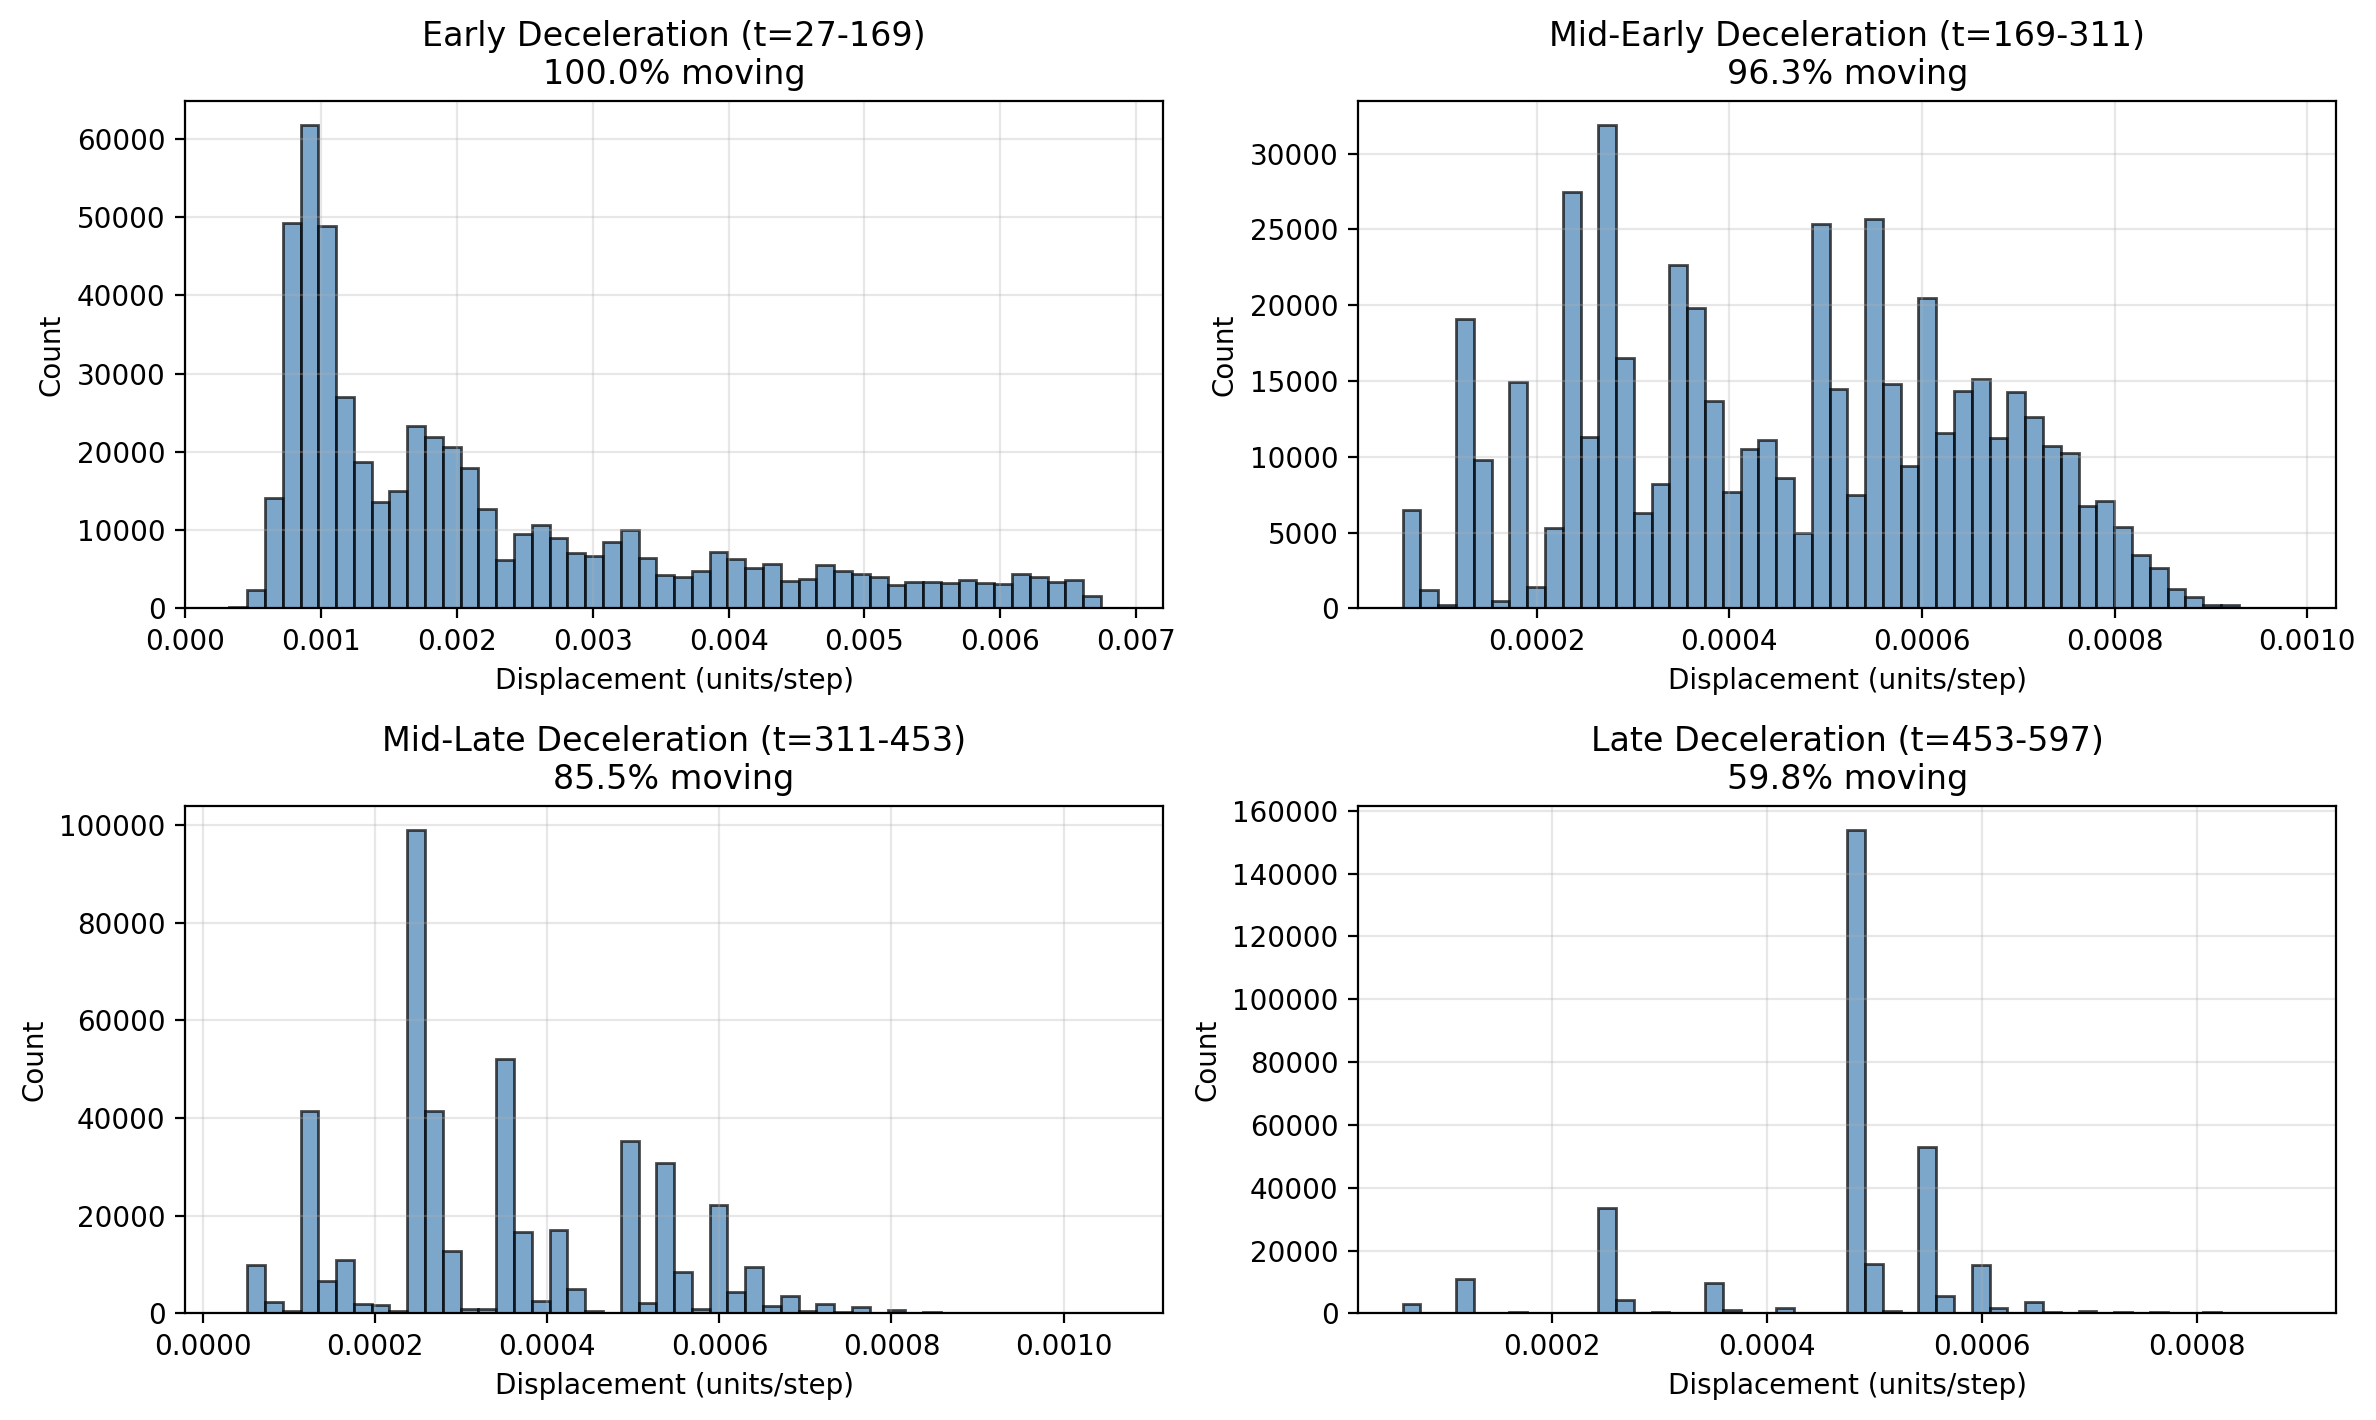

Interpretation: Watch for histograms becoming more discrete (quantized) as training progresses.
Early: Smooth distribution → Late: Discrete peaks (lattice hopping) → Frozen: Empty histogram


In [11]:
# Divide Deceleration into 4 phases
decel_duration = decel_end - decel_start
phase_size = decel_duration // 4

phases = [
    ("Early", decel_start, decel_start + phase_size),
    ("Mid-Early", decel_start + phase_size, decel_start + 2*phase_size),
    ("Mid-Late", decel_start + 2*phase_size, decel_start + 3*phase_size),
    ("Late", decel_start + 3*phase_size, decel_end),
]

fig, axes = plt.subplots(2, 2, figsize=(FIGSIZE[0], FIGSIZE[1]*1.2), dpi=DPI)
axes = axes.flatten()

for i, (label, start, end) in enumerate(phases):
    ax = axes[i]
    
    phase_displacements = displacements[start:end, :].flatten().numpy()
    
    # Remove zeros for histogram (frozen tokens)
    phase_nonzero = phase_displacements[phase_displacements > 0]
    fraction_moving = len(phase_nonzero) / len(phase_displacements)
    
    if len(phase_nonzero) > 0:
        ax.hist(phase_nonzero, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Displacement (units/step)')
        ax.set_ylabel('Count')
        ax.set_title(f'{label} Deceleration (t={start}-{end})\n{fraction_moving:.1%} moving')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'All tokens frozen', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{label} Deceleration (t={start}-{end})')

plt.tight_layout()
plt.show()

print("Interpretation: Watch for histograms becoming more discrete (quantized) as training progresses.")
print("Early: Smooth distribution → Late: Discrete peaks (lattice hopping) → Frozen: Empty histogram")

### Velocity Variance Over Time

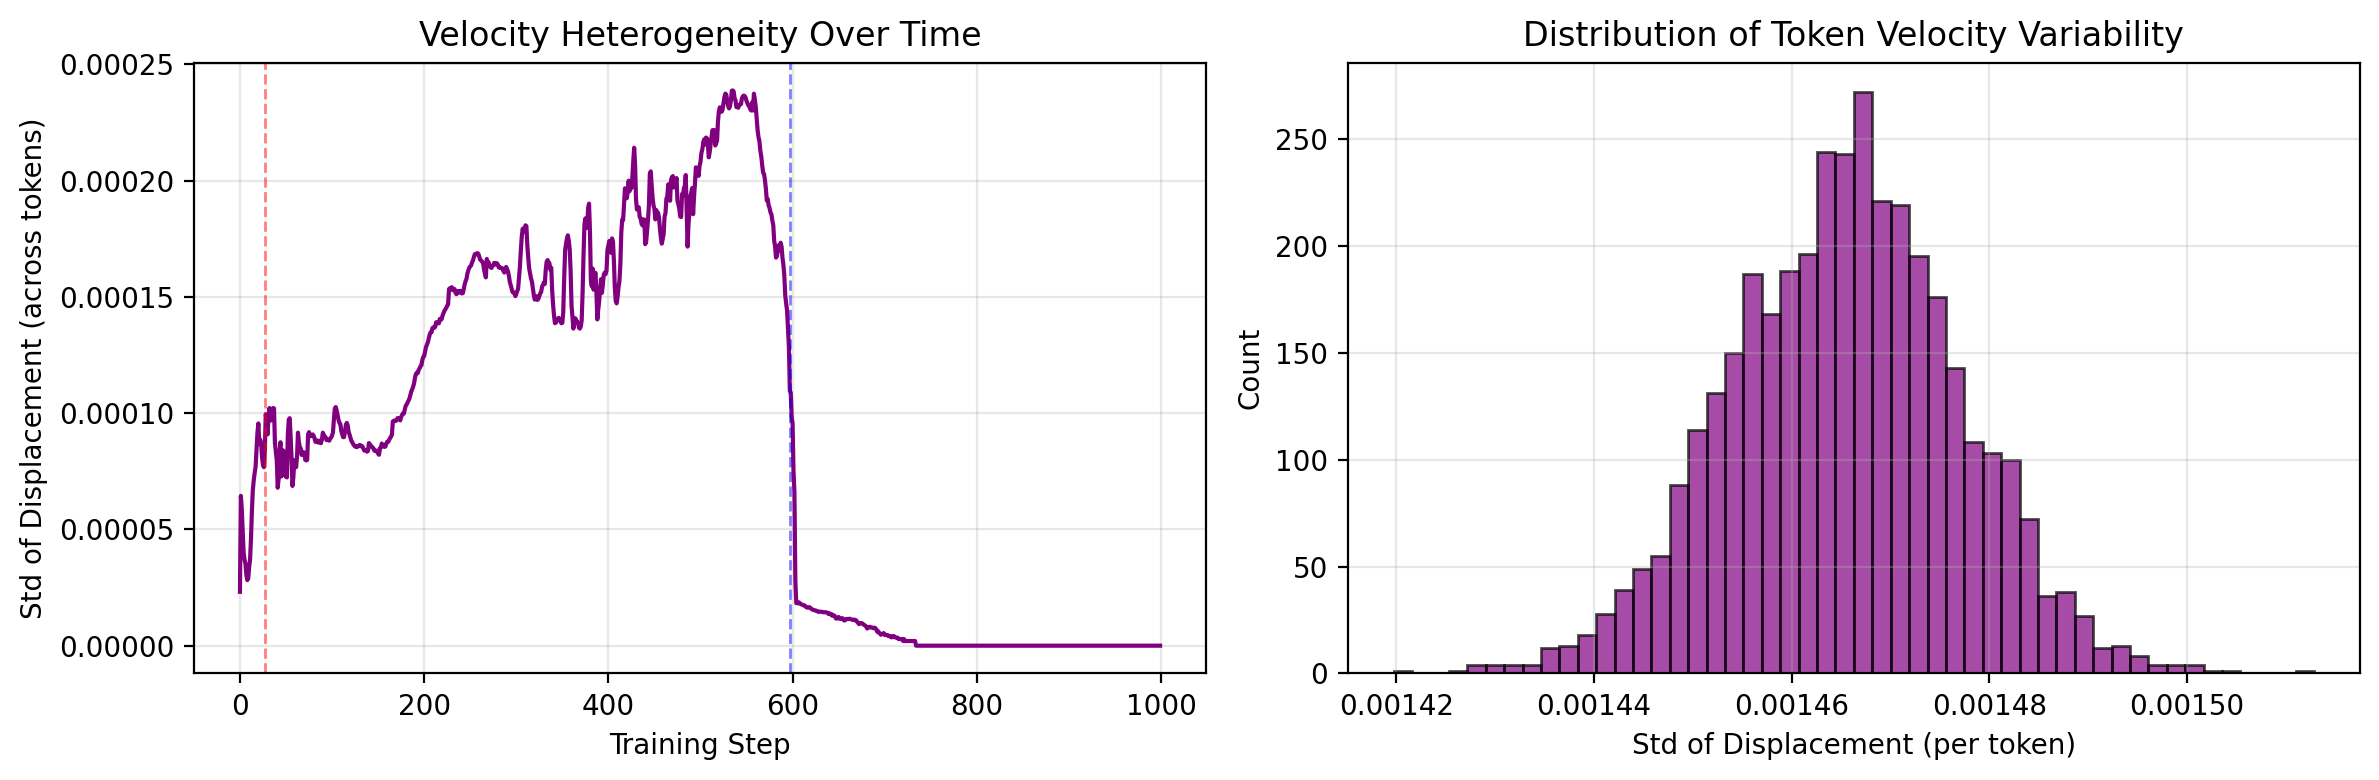

Interpretation: Spikes in variance indicate heterogeneous dynamics (some moving, some frozen).


In [12]:
# Per-token velocity variance
# For each token, compute std of displacements over time
per_token_velocity_std = displacements.std(dim=0)  # (3699,)

# Also compute variance of velocity at each timestep (across tokens)
per_step_velocity_std = displacements.std(dim=1)  # (1000,)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(FIGSIZE[0], FIGSIZE[1]//1.5), dpi=DPI)

# Variance over time
ax1.plot(per_step_velocity_std.numpy(), linewidth=1.5, color='purple')
ax1.axvline(t_sneeze_end, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.axvline(t_fimbulwinter_start, color='blue', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Std of Displacement (across tokens)')
ax1.set_title('Velocity Heterogeneity Over Time')
ax1.grid(True, alpha=0.3)

# Histogram of per-token variance
ax2.hist(per_token_velocity_std.numpy(), bins=50, color='purple', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Std of Displacement (per token)')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Token Velocity Variability')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation: Spikes in variance indicate heterogeneous dynamics (some moving, some frozen).")

### Fraction of Tokens: Moving / Hopping / Frozen

Hop threshold: 0.007545 units/step
(Median non-zero displacement during Sneeze)



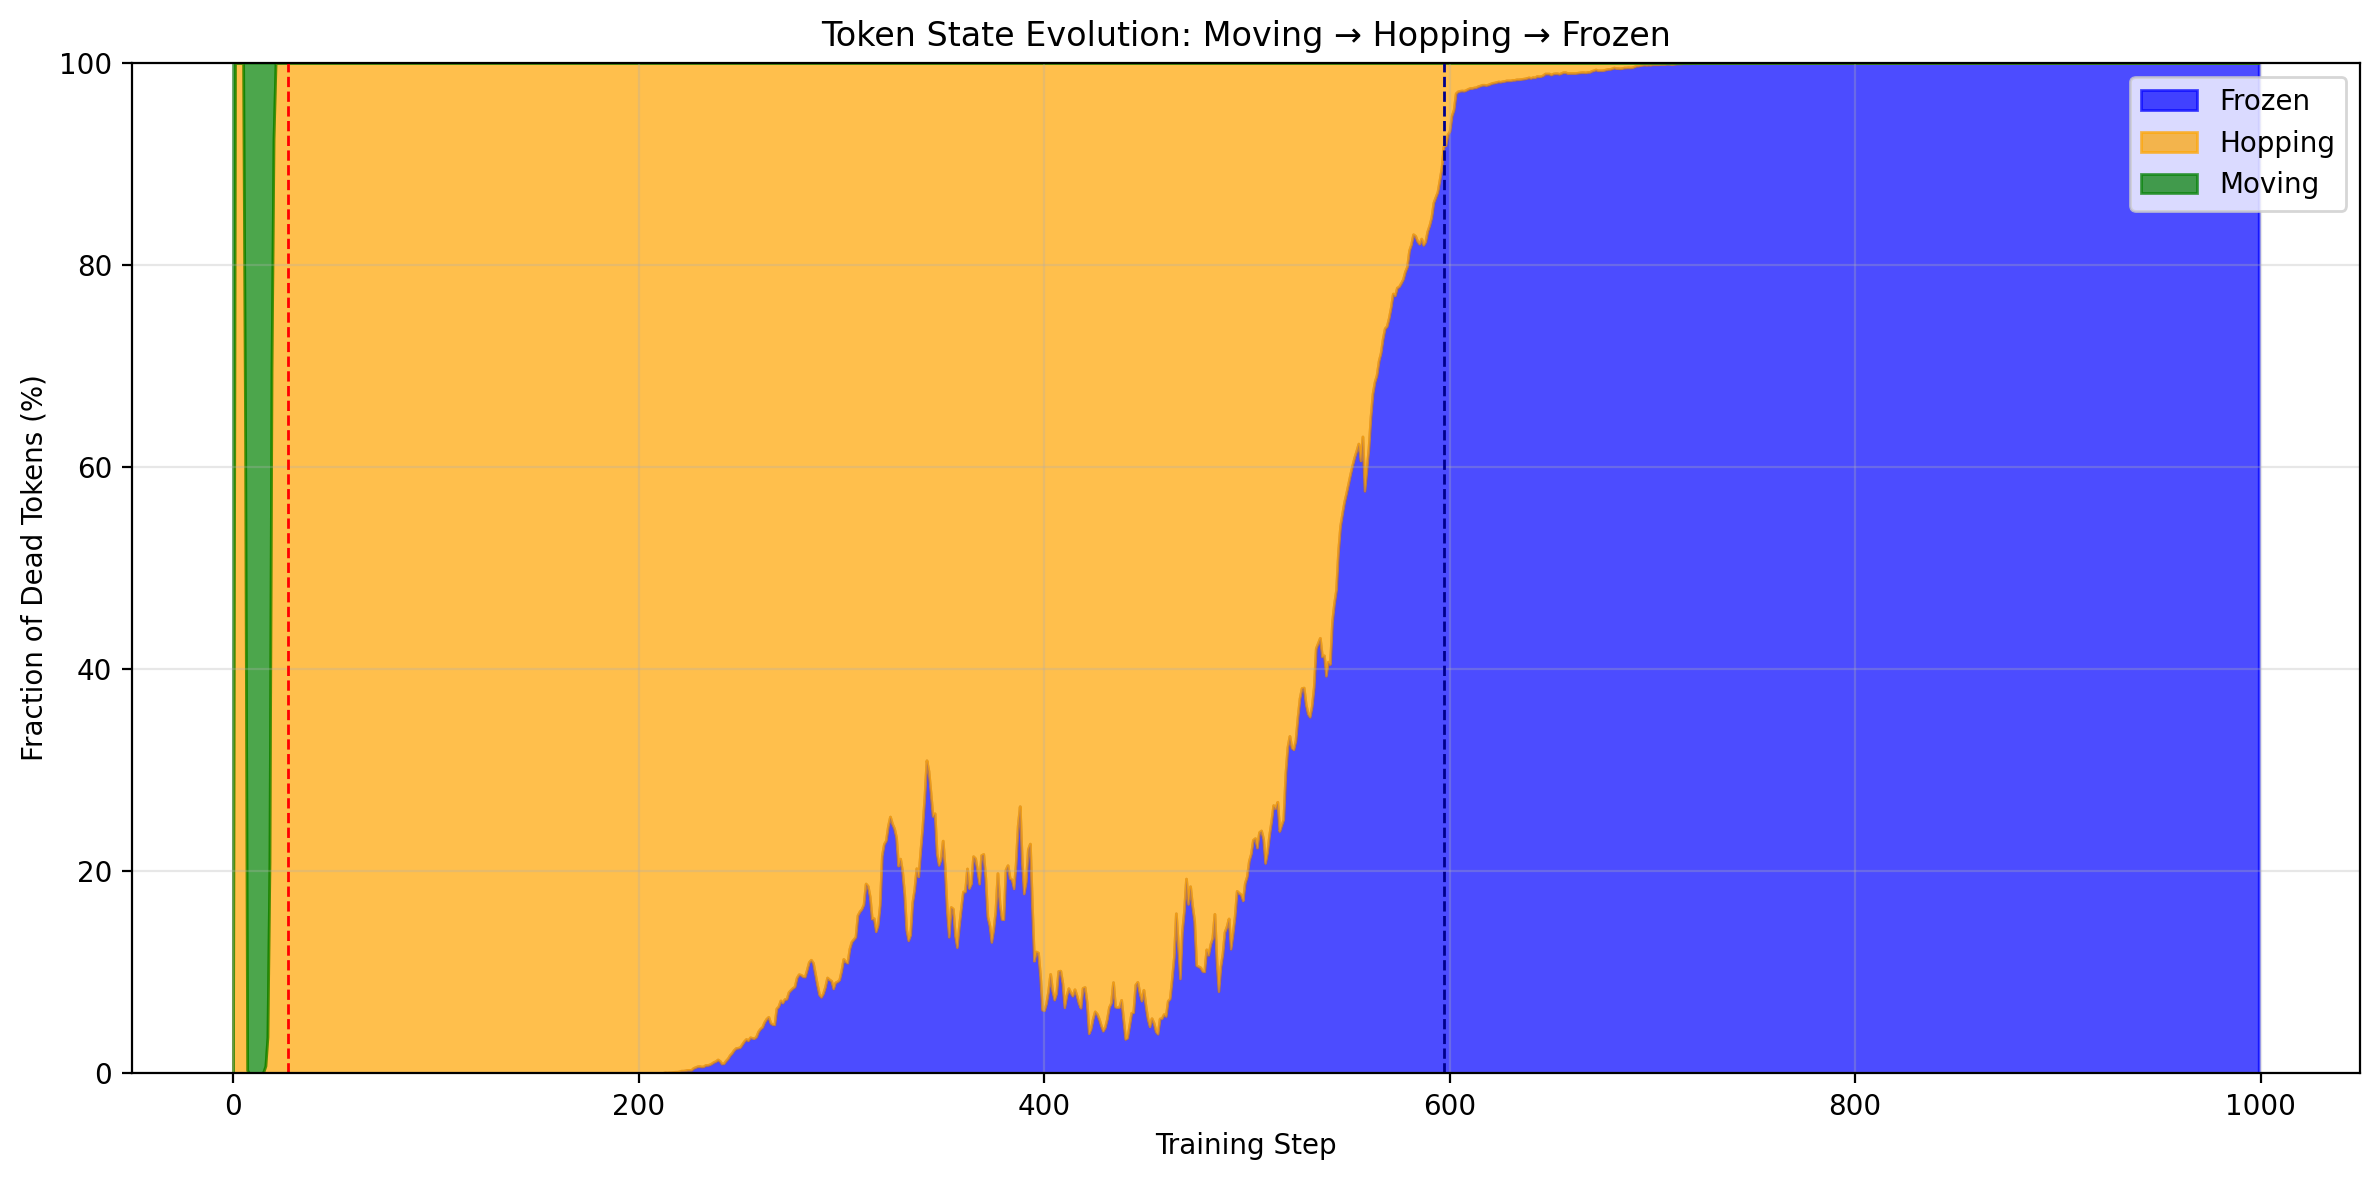

Interpretation: Transition from smooth motion → lattice hopping → complete freeze.
Deceleration should show growing orange region (heterogeneous dynamics).


In [13]:
# Classify tokens at each step
# Frozen: displacement = 0
# Hopping: 0 < displacement < threshold (small, quantized)
# Moving: displacement >= threshold (smooth, large)

# Define threshold as median of non-zero displacements in early Sneeze
early_displacements = displacements[:t_sneeze_end, :].flatten()
early_nonzero = early_displacements[early_displacements > 0]
hop_threshold = early_nonzero.median().item()

print(f"Hop threshold: {hop_threshold:.6f} units/step")
print(f"(Median non-zero displacement during Sneeze)\n")

# Classify
frozen = (displacements == 0).float().mean(dim=1)  # (1000,)
hopping = ((displacements > 0) & (displacements < hop_threshold)).float().mean(dim=1)
moving = (displacements >= hop_threshold).float().mean(dim=1)

# Plot stacked area
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.fill_between(range(len(frozen)), 0, frozen.numpy()*100, color='blue', alpha=0.7, label='Frozen')
ax.fill_between(range(len(frozen)), frozen.numpy()*100, (frozen+hopping).numpy()*100, color='orange', alpha=0.7, label='Hopping')
ax.fill_between(range(len(frozen)), (frozen+hopping).numpy()*100, 100, color='green', alpha=0.7, label='Moving')

ax.axvline(t_sneeze_end, color='red', linestyle='--', linewidth=1)
ax.axvline(t_fimbulwinter_start, color='darkblue', linestyle='--', linewidth=1)

ax.set_xlabel('Training Step')
ax.set_ylabel('Fraction of Dead Tokens (%)')
ax.set_title('Token State Evolution: Moving → Hopping → Frozen')
ax.legend(loc='upper right')
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation: Transition from smooth motion → lattice hopping → complete freeze.")
print("Deceleration should show growing orange region (heterogeneous dynamics).")

## Summary

In [14]:
print("\n" + "="*80)
print("EPOCH DETECTION SUMMARY")
print("="*80 + "\n")

print("Three Core Epochs:")
print(f"  1. The Sneeze:     t=0 → t={t_sneeze_end} ({t_sneeze_end} steps)")
print(f"  2. Deceleration:   t={t_sneeze_end} → t={t_fimbulwinter_start} ({t_fimbulwinter_start - t_sneeze_end} steps)")
print(f"  3. Fimbulwinter:   t={t_fimbulwinter_start} → t={len(mean_radius)-1} ({len(mean_radius) - 1 - t_fimbulwinter_start} steps)")
print()

print("Optional Features:")
if inhale_present:
    print(f"  ✓ Inhale detected at t={t_inhale_min} ({contraction*100:.2f}% contraction)")
else:
    print(f"  ✗ No inhale detected")

if reexpansion_present:
    print(f"  ✓ Re-expansion detected starting at t={t_reexpansion_start}")
else:
    print(f"  ✗ No re-expansion detected (monotonic deceleration)")

print()
print("Deceleration Dynamics:")
print(f"  Mean displacement: {decel_displacements.mean():.6f} units/step")
print(f"  Displacement std:  {decel_displacements.std():.6f} units/step")
print(f"  Hop threshold:     {hop_threshold:.6f} units/step")
print()

# Check for signs of chaos
late_decel_std = per_step_velocity_std[decel_start+decel_duration//2:decel_end].mean()
early_decel_std = per_step_velocity_std[decel_start:decel_start+decel_duration//2].mean()

if late_decel_std > early_decel_std * 1.2:
    print("✓ Heterogeneity increases in late Deceleration (chaotic dynamics)")
else:
    print("✗ No clear increase in heterogeneity (smooth deceleration)")

print("\n" + "="*80)
print("✓ Epoch detection complete.")
print("="*80)


EPOCH DETECTION SUMMARY

Three Core Epochs:
  1. The Sneeze:     t=0 → t=27 (27 steps)
  2. Deceleration:   t=27 → t=597 (570 steps)
  3. Fimbulwinter:   t=597 → t=1000 (403 steps)

Optional Features:
  ✓ Inhale detected at t=2 (0.55% contraction)
  ✓ Re-expansion detected starting at t=595

Deceleration Dynamics:
  Mean displacement: 0.000806 units/step
  Displacement std:  0.001145 units/step
  Hop threshold:     0.007545 units/step

✓ Heterogeneity increases in late Deceleration (chaotic dynamics)

✓ Epoch detection complete.
